In [1]:
import logging
import threading
import itertools
import pandas as pd  
import numpy as np  
import scipy as sp
import ruptures as rpt
import json
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns

import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import (StandardScaler, RobustScaler, MinMaxScaler,
                                   minmax_scale, PolynomialFeatures)
from sklearn import metrics
from pandas.plotting import register_matplotlib_converters

from scipy.stats.contingency import margins
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import gaussian_kde
from scipy.stats import skew

from pyod.models.copod import COPOD
import skimage as ski
from skimage import util as skiutil
register_matplotlib_converters()

In [2]:
# setting to make life easier
Temperature='Temperature'
kmeans0='TemperatureKmeansScore0'
kmeans='TemperatureKmeansScore'
fft0='FFTAnomalyScore0'
mat0='MatrixProfileAnomalyScore'
fft='FFTAnomalyScore'
spectral='TemperatureSpectralScore'
sal='SaliencyAnomalyScore'
gen='TemperatureGeneralizedScore'
kmeansA='kmeansAnomaly'
kmeansA0='kmeansAnomaly0'
spectralA='spectralAnomaly'
fftA0='fftAnomaly0'
fftA='fftAnomaly'
salA='salAnomaly'
genA='genAnomaly'
matA0='matAnomaly'

kmeans_break=1.3
spectral_break = 100
fft_break = 100
sal_break = 100
gen_break = 30000
mat_break = 1

In [3]:
# Get stuff in
df_i = pd.read_csv('./data/AzureAnomalysample.csv', index_col=False, parse_dates=['timestamp'])

df_i['entity']='MyRoom'
df_i[Temperature]=df_i['value']
#df_i = df_i.drop(columns=['value'])

# and sort it by timestamp
df_i = df_i.sort_values(by='timestamp')
df_i = df_i.set_index(['entity','timestamp']).dropna()

df_i.head(2)

value  Temperature
entity timestamp                              
MyRoom 2017-10-09 20:32:00    3.0          3.0
       2017-10-09 20:33:00    3.0          3.0

In [196]:
# data is evenly spaced, no need to resample - just extract

temperature = df_i['value'].values
temp_win = skiutil.view_as_windows(temperature, window_shape=(2,), step=1)

In [197]:
# turned my data into 2-dim vectors for anomaly scoring
temp_win.shape

(3999, 2)

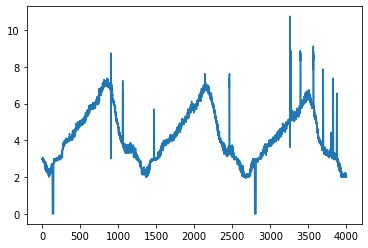

In [198]:
#plot original
plt.plot(range(len(temperature)), temperature)

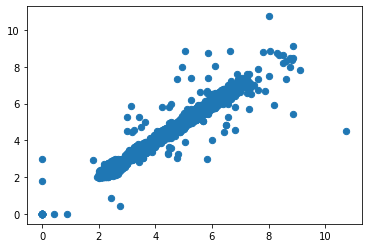

In [199]:
# plot 2-dim
plt.scatter(temp_win[:, 0], temp_win[:, 1], s=40, cmap='viridis');

### Approximate as Gaussian

In [200]:
from scipy.interpolate import interp1d

#temp_scal = MinMaxScaler().fit_transform(temperature.reshape(-1, 1))
temp_scal = temperature
temp_dist = gaussian_kde(temp_scal.reshape(-1,))
t_min = temp_scal.min()
t_max = temp_scal.max()

temp_func = interp1d(range(len(temperature)), temperature, kind = 'cubic')

In [201]:
dist_x = np.arange(t_min,t_max, 0.005)
dist_y = temp_dist(dist_x)

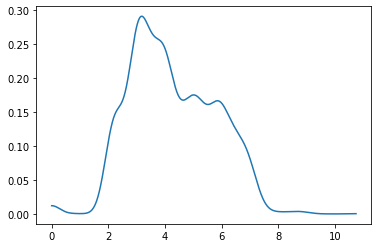

In [202]:
plt.plot(dist_x, dist_y)

In [203]:
len(temperature)

4000

In [204]:
from scipy.integrate import (romberg, simpson)
romberg(temp_func, t_min, t_max)

32.019010210340426

In [205]:
# find max
i_max = np.argmax(dist_y)
x_max = dist_x[i_max]

dist_1st = np.diff(dist_y)

hess_f = np.diff(dist_1st*100)

# find min gradient in vicinity


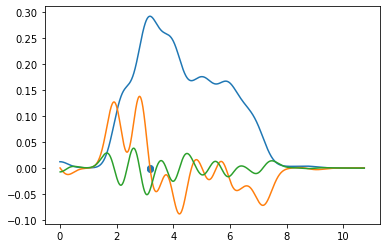

In [206]:
plt.plot(dist_x, dist_y)
plt.plot(dist_x[1:], dist_1st*100)
plt.plot(dist_x[2:], hess_f*20)
plt.scatter(dist_x[i_max-1:i_max+1], dist_1st[i_max-1:i_max+1]*100)

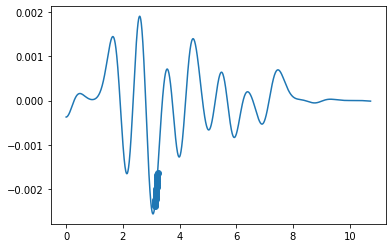

In [207]:
plt.plot(dist_x[:-2], hess_f)
plt.scatter(dist_x[i_max-10:i_max+10], hess_f[i_max-10:i_max+10])

$$
    ln(f(z) = ln(f(z_{0})) - \frac{1}{2}\mathcal{A}(z - z_{0})^{2} \ with\  \mathcal{A} = - \frac{d^{2}}{dz^{2}}f(z)\biggr\rvert_{z_{0}}
$$

$$
                f(z) = f(z_{0}) exp\biggr\{-\frac{\mathcal{A}}{2}(z - z_{0})^2 \biggr\}
$$

 with normalization we get, so essentially the curvature around the peak determines the precision
 
$$
    \mathcal{N}(z_{0}, \mathcal{A}^{-1})
$$

In [208]:
# curvature around the peak
A = -np.min(hess_f[i_max-6:i_max+6])
"mean", x_max, "sigma", 1/A

('mean', 3.18, 'sigma', 444.529855564689)

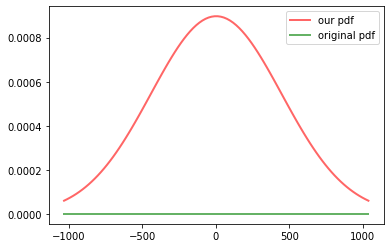

In [209]:
from scipy.stats import norm
#approx = norm.pdf(x, x_max, 1/A)

x_grid = np.linspace(norm.ppf(0.01, loc=x_max, scale=1/A),
                norm.ppf(0.99, loc=x_max, scale=1/A), 100)
plt.plot(x_grid, norm.pdf(x_grid, loc=x_max, scale=1/A),
       'r-', lw=2, alpha=0.6, label='our pdf')
plt.plot(x_grid, temp_dist(x_grid),
       'g-', lw=2, alpha=0.6, label='original pdf')
plt.legend()

### Apply COPOD

as well as ECOD

For java have a look at [EmpiricalDistribution in Common Math](https://commons.apache.org/proper/commons-math/javadocs/api-3.6/org/apache/commons/math3/random/EmpiricalDistribution.html) and [Skewness in Common Math](https://commons.apache.org/proper/commons-math/javadocs/api-3.6/org/apache/commons/math3/stat/descriptive/moment/Skewness.html)

In [210]:

def ecdf(X):
    ecdf = ECDF(X)
    return ecdf(X)

In [211]:
temp_win.shape

(3999, 2)

### Constructing the Copula

For each dimension we approximate
$$
    P(\{X_{i} < X \})
$$
with the empirical CDF for each dimension i.

This is independent of all other dimensions, so it's the marginal (e)CDF.

Since these marginal CDFs uniquely determine the joint CDF, the idea behind COPOD is to analyze the marginal CDFs.

In [212]:
# compute P({t < x}) and P({t < -x}) for each dimension according to the empirical CDF ()
#
left_log_univariate_cdfs = -1 * np.log(np.apply_along_axis(ecdf, 0, temp_win))
right_log_univariate_cdfs = -1 * np.log(np.apply_along_axis(ecdf, 0, -temp_win))

In [213]:
left_log_univariate_cdfs.shape

(3999, 2)

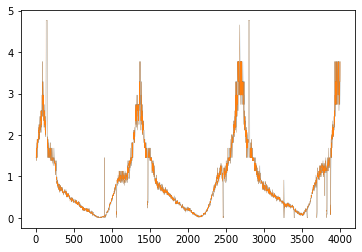

In [214]:
plt.plot(range(len(left_log_univariate_cdfs[:, 0])), left_log_univariate_cdfs[:,0], lw=0.2)
plt.plot(range(len(left_log_univariate_cdfs[:, 1])), left_log_univariate_cdfs[:,1], lw=0.2);

In [215]:
# COPOD: adjust for skewness (more weight on left or right tail) for each dimension
skewness = np.sign(skew(temp_win, axis=0))
skewness

array([1., 1.])

In [216]:
U_skew = left_log_univariate_cdfs * -1 * np.sign(skewness - 1) + right_log_univariate_cdfs  * np.sign(skewness + 1)
U_skew.shape

(3999, 2)

In [217]:
# COPOD: adjust for skewness (more weight on left or right tail) for each dimension
skewness = np.sign(skew(temp_win, axis=0))

# apply skewness for each dimension: either take from the right or the left tail.
U_skew = left_log_univariate_cdfs * -1 * np.sign(skewness - 1) + right_log_univariate_cdfs  * np.sign(skewness + 1)
O = np.maximum(U_skew, np.add(left_log_univariate_cdfs, right_log_univariate_cdfs) / 2)

In [218]:
O.shape

(3999, 2)

In [219]:
# ECOD
O_ecod = np.maximum(U_skew, left_log_univariate_cdfs, right_log_univariate_cdfs)

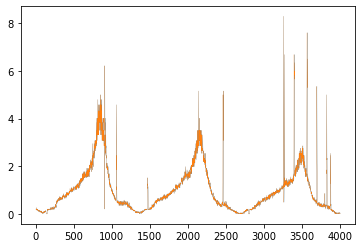

In [220]:
plt.plot(range(len(U_skew[:, 0])), U_skew[:,0], lw=0.2)
plt.plot(range(len(U_skew[:, 1])), U_skew[:,1], lw=0.2);

In [221]:
decision_score = O.sum(axis=1)
decision_score_e = O_ecod.sum(axis=1)

In [222]:
decision_score.shape

(3999,)

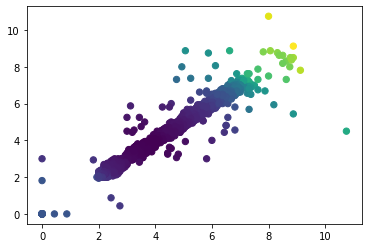

In [223]:
# outliers in 2-d
plt.scatter(temp_win[:, 0], temp_win[:, 1], c=decision_score, s=40, cmap='viridis');

In [224]:
dfff0 = pd.read_csv('/home/markus/src/pipeline-2.0-poc-kafka/com.ibm.wiotp.internal.pipeline.catalog/src/test/resources/AzureAnomalysample.csv')

In [225]:
dfff0_win = skiutil.view_as_windows(temperature, window_shape=(12,), step=2)

In [226]:
dfff0_win.shape

(1995, 12)

In [227]:
def COPOD(twin):
    left_log_univariate_cdfs2 = -1 * np.log(np.apply_along_axis(ecdf, 0, twin))
    right_log_univariate_cdfs2 = -1 * np.log(np.apply_along_axis(ecdf, 0, -twin))
    skewness2 = np.sign(skew(twin, axis=0))
    U_skew = left_log_univariate_cdfs2 * -1 * np.sign(skewness2 - 1) + right_log_univariate_cdfs2  * np.sign(skewness2 + 1)
    #O = np.maximum(U_skew, np.add(left_log_univariate_cdfs2, right_log_univariate_cdfs2) / 2)
    O = np.maximum(U_skew, left_log_univariate_cdfs2, right_log_univariate_cdfs2)
    decision_score = O.sum(axis=1)
    return decision_score, left_log_univariate_cdfs2, right_log_univariate_cdfs2, O

In [228]:
copod, ll, rr, O = COPOD(dfff0_win)

In [231]:
O.sum(axis=1)

array([18.38568074, 19.09060543, 19.32480823, ..., 37.59541762,
       38.62732149, 40.22874981])

In [232]:
ll[6], rr[6], O[6], copod[6], O[6].sum()

(array([1.82384778, 1.83007833, 1.695766  , 1.45851478, 1.69303748,
        1.90130584, 1.69031639, 1.89795576, 1.46500129, 1.81765581,
        1.68489632, 1.81457415]),
 array([1.82384778, 1.83007833, 1.695766  , 1.45851478, 1.69303748,
        1.90130584, 1.69031639, 1.89795576, 1.46500129, 1.81765581,
        1.68489632, 1.81457415]),
 array([1.82384778, 1.83007833, 1.695766  , 1.45851478, 1.69303748,
        1.90130584, 1.69031639, 1.89795576, 1.46500129, 1.81765581,
        1.68489632, 1.81457415]),
 20.772949932045186,
 20.772949932045186)

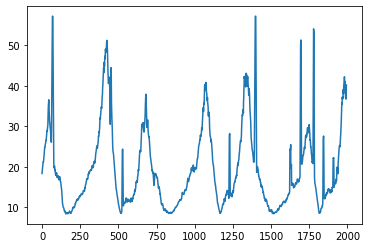

In [233]:
plt.plot(range(copod.shape[0]),copod)


In [1]:
dfff0a = pd.read_csv('/home/markus/src/pipeline-2.0-poc-kafka/com.ibm.wiotp.internal.pipeline.catalog/src/test/resources/AzureAnomalysample.csv')
dfff0a['timestamp'] = pd.to_datetime(dfff0a['timestamp'])        
dfff0a = dfff0a.set_index('timestamp').interpolate(method="time").resample('1T').asfreq().interpolate(method="time")
#dfff0a['timestamp'][0]
dfff0a.plot()
dfff0.set_index('timetick').plot()
dfff0a.shape

NameError: name 'pd' is not defined

In [398]:
dfff0a['nval'] = (dfff0a['value'].values - dfff0['value'].values)

<AxesSubplot:xlabel='timestamp'>

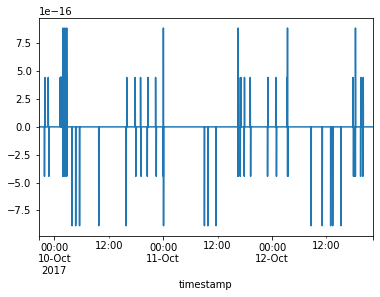

In [399]:
dfff0a['nval'].plot()

In [55]:
dfff0 = pd.read_csv('/home/markus/src/pipeline-2.0-poc-kafka/com.ibm.wiotp.internal.pipeline.catalog/src/test/resources/test.csv')
dfff0a = pd.read_csv('/home/markus/src/pipeline-2.0-poc-kafka/com.ibm.wiotp.internal.pipeline.catalog/src/test/resources/AzureAnomalysample.csv')

dfff1 = pd.read_csv('/home/markus/src/pipeline-2.0-poc-kafka/com.ibm.wiotp.internal.pipeline.catalog/src/test/resources/AzureAnomalyCOPODScores.csv')
dfff2 = pd.read_csv('/home/markus/src/pipeline-2.0-poc-kafka/com.ibm.wiotp.internal.pipeline.catalog/src/test/resources/AzureAnomalyKMeansScores.csv')

#dfff3 = pd.read_csv('/home/markus/src/pipeline-2.0-poc-kafka/com.ibm.wiotp.internal.pipeline.catalog/src/test/resources/AzureAnomalyMatrixProfileScores.csv')


In [170]:
dfff4 = pd.read_csv('/home/markus/src/pipeline-2.0-poc-kafka/com.ibm.wiotp.internal.pipeline.catalog/src/test/resources/AzureAnomalyKNNKDEScores.csv')
dfff5 = pd.read_csv('/home/markus/src/pipeline-2.0-poc-kafka/com.ibm.wiotp.internal.pipeline.catalog/src/test/resources/AzureAnomalyIsolationScores.csv')

<AxesSubplot:>

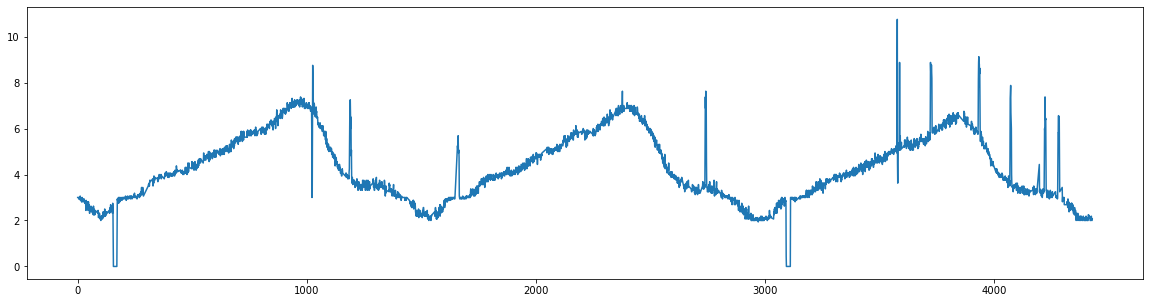

In [171]:
dfff0['value'].plot(figsize=(20,5))

<AxesSubplot:>

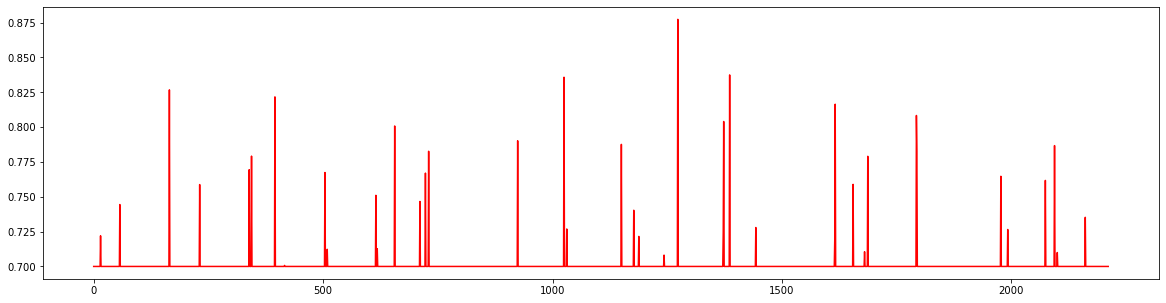

In [172]:
dfff5[dfff5['value'] < 0.7] = 0.7
dfff5['value'].plot(figsize=(20,5), color='red')

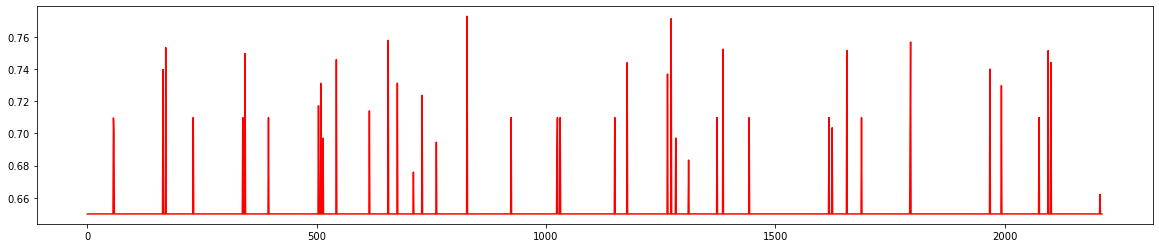

In [127]:
from matplotlib.pyplot import figure

dfff5[dfff5['value'] < 0.55] = np.nan

figure(figsize=(20,4))
plt.plot(dfff5.index, dfff5['value'], color='red')
#dfff5['value'].plot(figsize=(20,4))

In [779]:
dfff5

,timetick,value
0,1507581120000,0.621215
1,1507581180000,0.621215
2,1507581240000,0.621215
3,1507581300000,0.621215
4,1507581360000,0.621215
...,...,...
2209,1507713660000,0.683272
2210,1507713720000,0.651505
2211,1507713780000,0.621215
2212,1507713840000,0.621215


<AxesSubplot:>

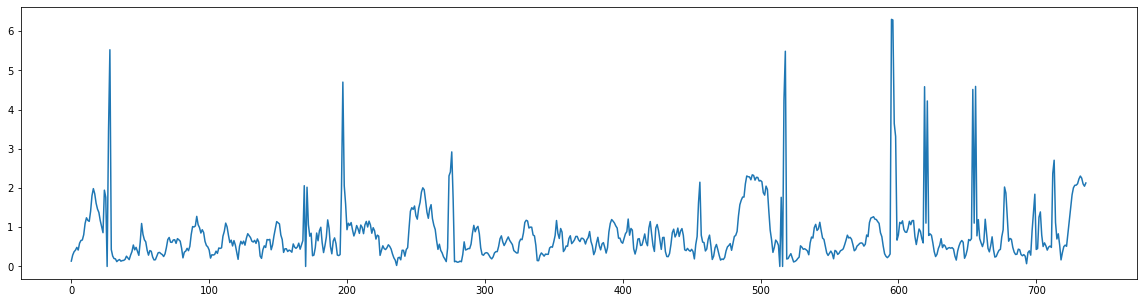

In [615]:
#dfff0['value'].plot()
dfff2['value'].plot(figsize=(20,5))


<AxesSubplot:>

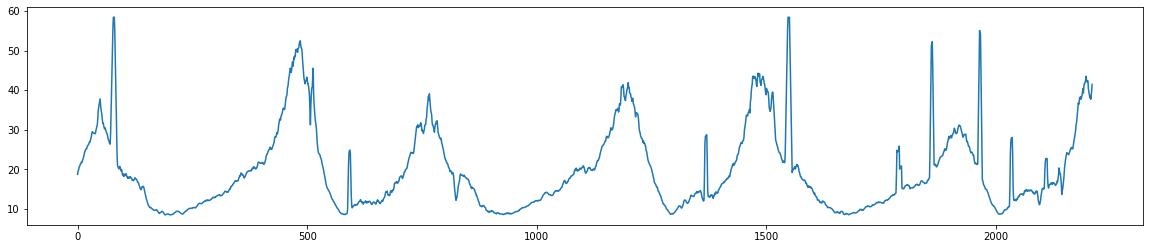

In [574]:
dfff1['value'].plot(figsize=(20,4))


<AxesSubplot:>

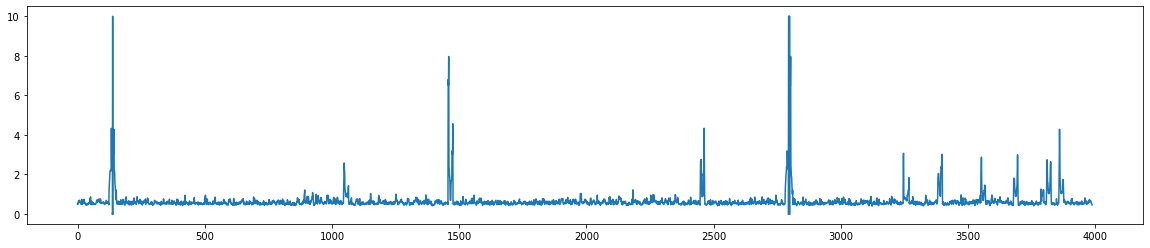

In [577]:
dfff3['value'].plot(figsize=(20,4))

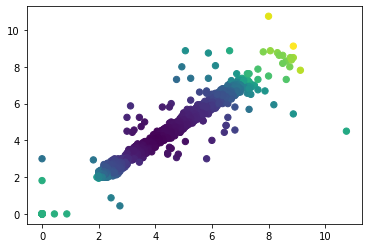

In [556]:
# outliers in 2-d - ECOD
plt.scatter(temp_win[:, 0], temp_win[:, 1], c=decision_score_e, s=40, cmap='viridis');

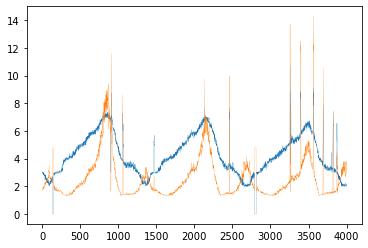

In [125]:
plt.plot(range(len(temperature)), temperature, lw=0.2)
plt.plot(range(len(decision_score)), score, lw=0.2);

### ECDF 

In [258]:
# ECDF copied-and-pasted from Java output
ecdf_ = [0.0, 0.4588094349656101, 0.6692400851924782, 0.7845473187982682, 0.8549491791835158, 0.8899540042725554, 0.9150000000000003, 0.9300000000000003, 0.9500000000000003, 0.9600000000000003, 0.9650000000000003, 0.9650000000000003, 0.9650000000000003, 0.9700000000000003, 0.9750000000000003, 0.9850000000000003, 0.9850000000000003, 0.9850000000000003, 0.9850000000000003, 0.9800000000000003, 0.9900000000000003, 0.9900000000000003, 0.9900000000000003, 0.9900000000000003, 0.9900000000000003, 0.9900000000000003, 0.9950000000000003, 0.9950000000000003, 0.9950000000000003, 0.9950000000000003, 0.9950000000000003, 0.9950000000000003, 0.9950000000000003, 0.9950000000000003, 0.9950000000000003, 0.9950000000000003, 0.9950000000000003, 0.9950000000000003, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
ecdf = np.array(ecdf_).flatten()

Text(0.5, 1.0, "ECDF''")

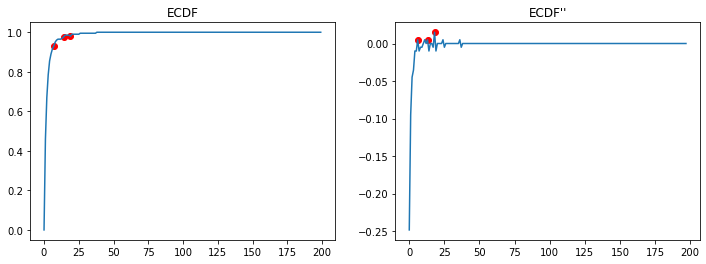

In [283]:
i = len(ecdf)
ecdf_p = np.diff(ecdf)
ecdf_pp = np.diff(ecdf_p)
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter([7,14,19], [ecdf[7],ecdf[14],ecdf[19]], c='red')
ax[0].plot(range(i),ecdf)
ax[0].set_title('ECDF')
#ax[1].plot(range(i-1), ecdf_p)
ax[1].plot(range(i-2), ecdf_pp)
# first difference > 0, second > 0 => knee
ax[1].scatter([6,13,18], [ecdf_pp[6],ecdf_pp[13],ecdf_pp[18]], c='red')
ax[1].set_title('ECDF\'\'')



### Knee

found a knee point

In [276]:
dff4 = pd.read_csv('/home/markus/src/pipeline-2.0-poc-kafka/com.ibm.wiotp.internal.\
pipeline.catalog/src/test/resources/Outage2015_Severity.csv')

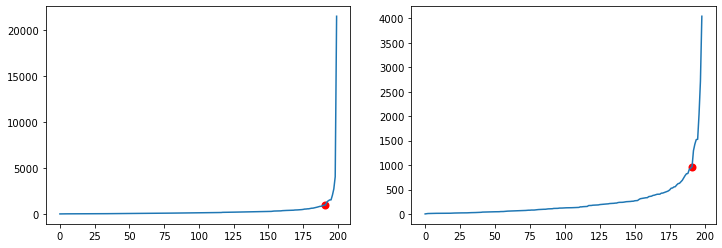

In [227]:
fig, ax = plt.subplots(1,2,figsize=(12,4))

ax[0].plot(dff4.index, dff4['SevMinutes'])
ax[0].scatter(dff4.index[191], dff4['SevMinutes'][191],c='red', lw=2)

ax[1].plot(ecdf, dff4['SevMinutes'].values[0:-1])
#ax[1].scatter(dff4.index[191], dff4['SevMinutes'][191],c='red', lw=2)


### Fit LogNormal for full data set

200


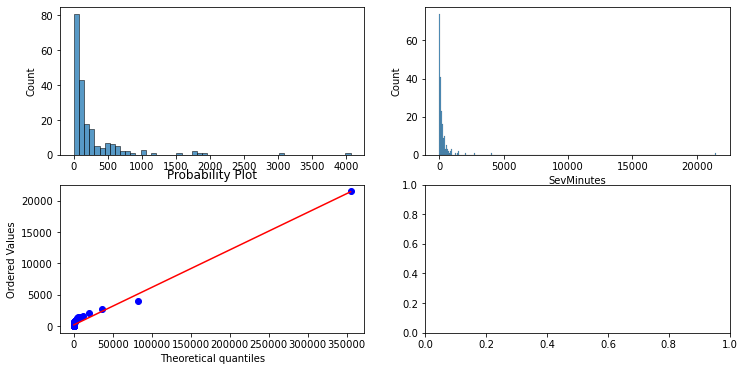

In [279]:

#Results Weibull: alpha = 0.6658971707994664, lambda = 0.004414077399301761, delta 0.0,
#Results Lognormal: mu = 4.73207991112077, sigma = 1.3756516502400118, 
from scipy.stats import weibull_min, lognorm
from scipy import stats
#x = np.random.weibull(0.6658971707994664, dff4['SevMinutes'].values.shape[0])/0.004414077399301761
x = np.random.lognormal(mean=4.73207991112077, sigma=1.3756516502400118, size=dff4['SevMinutes'].values.shape[0] )
print(x.size)

fig, ax = plt.subplots(2,2,figsize=(12,6))

sns.histplot(x, ax=ax[0,0])
sns.histplot(dff4['SevMinutes'], ax=ax[0,1])
#fig = stats.probplot(dff4['SevMinutes'], dist=stats.weibull, sparams=(0.6658971707994664,0.004414077399301761), plot=ax[1,0])
fig = stats.probplot(dff4['SevMinutes'], dist=stats.lognorm, sparams=(4.73207991112077,1.3756516502400118), plot=ax[1,0])


### Fit Lognormal to tail

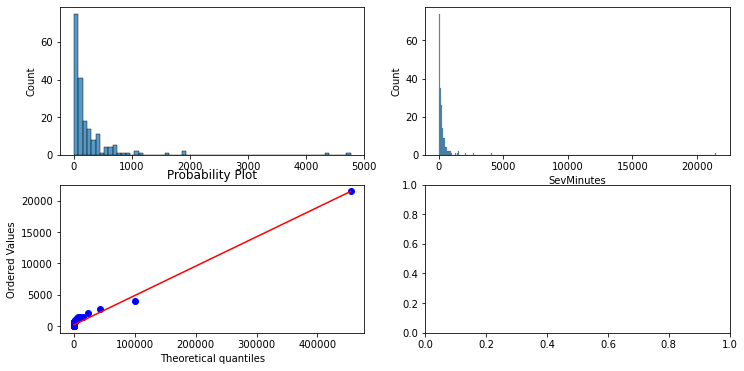

In [282]:
# Results Weibull: alpha = 0.8232125110969359, lambda = 0.0014260298318944135, delta 0.0, 
# Results LogNormal: mu = 4.8480143881917455, sigma = 1.2688748967345234, 


#x = np.random.weibull(0.8232125110969359, dff4['SevMinutes'].values.shape[0]-1)/0.0014260298318944135
x = np.random.lognormal(mean=4.8480143881917455, sigma=1.2688748967345234, size=dff4['SevMinutes'].values.shape[0]-8 )

fig, ax = plt.subplots(2,2,figsize=(12,6))

sns.histplot(x, ax=ax[0,0])
sns.histplot(dff4['SevMinutes'][8:], ax=ax[0,1])
#fig = stats.probplot(dff4['SevMinutes'], dist=stats.weibull, sparams=(0.6658971707994664,0.004414077399301761), plot=ax[1,0])
fig = stats.probplot(dff4['SevMinutes'][8:], dist=stats.lognorm, sparams=(4.8480143881917455,1.2688748967345234), plot=ax[1,0])
